In this exercise we will revisit the [Voles datasest](http://bit.ly/2IgDF0E) from the [Unit 6 assignment](https://github.com/UNC-DATA-730/a05/blob/main/assignment6.ipynb).

In [4]:
library('tidymodels')

In [5]:
df_voles = readr::read_csv('http://bit.ly/2IgDF0E', col_types = readr::cols())

df_voles |> head()

site,voles,veg,soil
<dbl>,<dbl>,<dbl>,<chr>
1,17,4,moist
2,30,33,moist
3,54,94,moist
4,49,64,moist
5,34,32,moist
6,48,76,moist


Plot the `voles` variable (outcome) versus `veg` variable (explanatory).

`geom_smooth()` using formula = 'y ~ x'


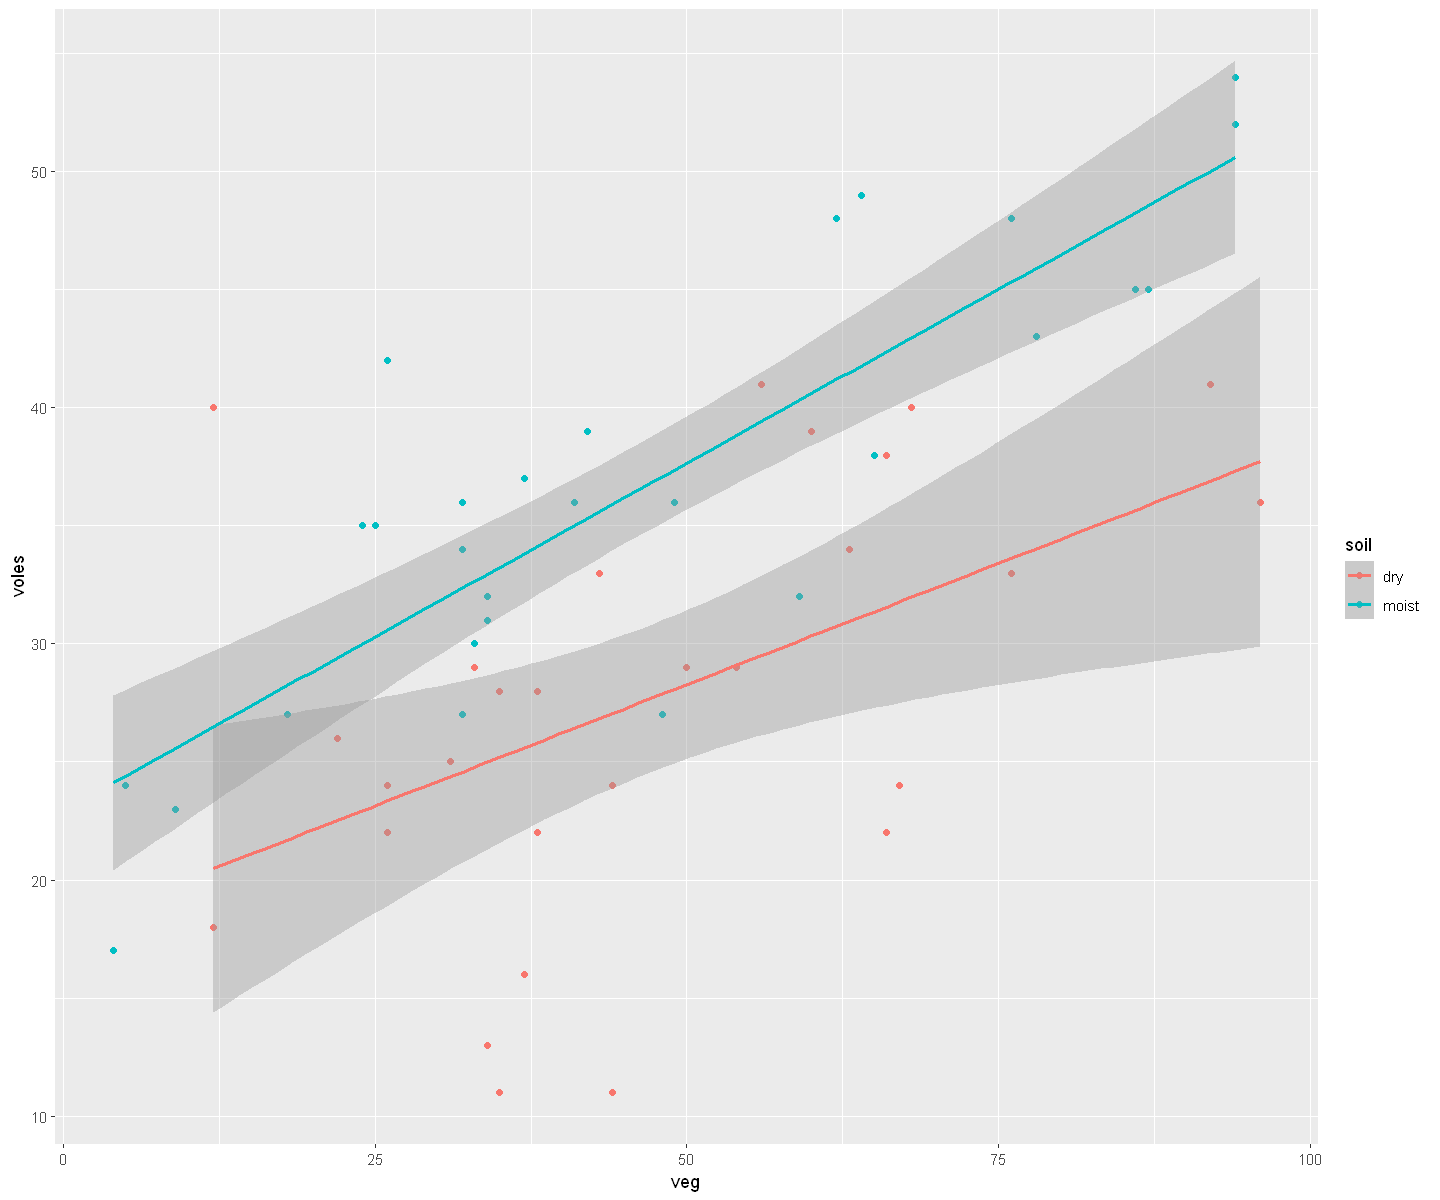

In [16]:
options(repr.plot.height = 10, repr.plot.width = 12)

ggplot(df_voles, aes(x = veg, y = voles, color = soil)) +
  geom_point() + stat_smooth(method = "lm")

Make a linear, parallel slopes model of `voles` versus `veg` and `soil`. What is the value for the `veg` term coefficient?

1. Create your model with `linear_reg` and `set_engine`.
2. Make a `recipe` to transform your data. `soil` should be dummy encoded (hint: use `step_dummy`). *Don't forget to `prep` your recipe!*.
3. Fit your model with data transformed using the recipe (hint: use `juice`).
4. Show your regression table with `tidy`.

In [ ]:
mod <- linear_reg() |> set_engine('lm')

rec <- recipe(voles ~ veg + soil, data = df_voles) |>
#  step_naomit(voles) |>
  step_dummy(soil) |>
  prep()

mod_fit = mod |> fit(voles ~ ., data = rec |> juice())
mod_fit |> tidy()


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),15.4640264,2.19678073,7.039404,3.897309e-09
veg,0.2590689,0.03787676,6.839785,8.166741e-09
soil_moist,9.1002980,1.79950838,5.057102,5.429719e-06


Let's see how sampling variability affects the `veg` term.

In [26]:
# create 1,000 bootstrap samples from the original data
boots = bootstraps(df_voles, times = 1000, apparent = TRUE)
boots |> glimpse()

Rows: 1,001
Columns: 2
$ splits <list> [<boot_split[56 x 22 x 56 x 4]>], [<boot_split[56 x 19 x 56 x …
$ id     <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstrap00…


What column holds your bootstrap samples?

# splits

We can use the map function from `purrr` to create a model from every bootstrap sample.

In [27]:
boot_models <- boots |>
  mutate(model = map(splits, ~mod |> fit(voles ~ ., data = bake(rec, new_data = .x))))

boot_models |> glimpse()

Rows: 1,001
Columns: 3
$ splits <list> [<boot_split[56 x 22 x 56 x 4]>], [<boot_split[56 x 19 x 56 x …
$ id     <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstrap00…
$ model  <list> [NULL, ~NULL, ~NULL, regression, FALSE, stats, formula, formul…


Now we need to create a regression table for all our models. Try to build this `purrr` function yourself.

(Hint: if you want to run `tidy` for all the models in a column called `model`, you might use `map(model, tidy))` inside of `mutate`.

In [31]:
boot_models |> mutate(coef_info = map(model, tidy)) |> glimpse()

Rows: 1,001
Columns: 4
$ splits    <list> [<boot_split[56 x 22 x 56 x 4]>], [<boot_split[56 x 19 x 56…
$ id        <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstra…
$ model     <list> [NULL, ~NULL, ~NULL, regression, FALSE, stats, formula, for…
$ coef_info <list> [<tbl_df[3 x 5]>], [<tbl_df[3 x 5]>], [<tbl_df[3 x 5]>], [<…


In [ ]:
reg_tables <- boot_models |> mutate(reg_table = map(model, tidy)) |>
  select(-splits, -model) |>
  unnest(reg_table)

reg_tables |> head()

id,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Bootstrap0001,(Intercept),14.5209490,2.32951603,6.233462,7.679624e-08
Bootstrap0001,veg,0.2497558,0.04339837,5.754958,4.431214e-07
Bootstrap0001,soil_moist,8.4634510,1.77129038,4.778127,1.442456e-05
Bootstrap0002,(Intercept),17.3410186,1.67025756,10.382242,2.229300e-14
Bootstrap0002,veg,0.2687028,0.02594007,10.358602,2.418948e-14
Bootstrap0002,soil_moist,6.7540159,1.48050411,4.561970,3.036885e-05


Last, we need to "unnest" the regression table information. 

In this step,
1. Use `select` to remove the `model` and `splits` columns.
2. Pipe this table into the `unnest` function with the column name for your regression table as the argument.
3. Preview the output.

Make a histogram of your `veg` coefficients 📊. 

[Here is what I found.](https://github.com/UNC-DATA-730/lecture-notebooks/blob/main/09-inference-for-regression/in-class-exercises/solution-histogram.png?raw=true)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


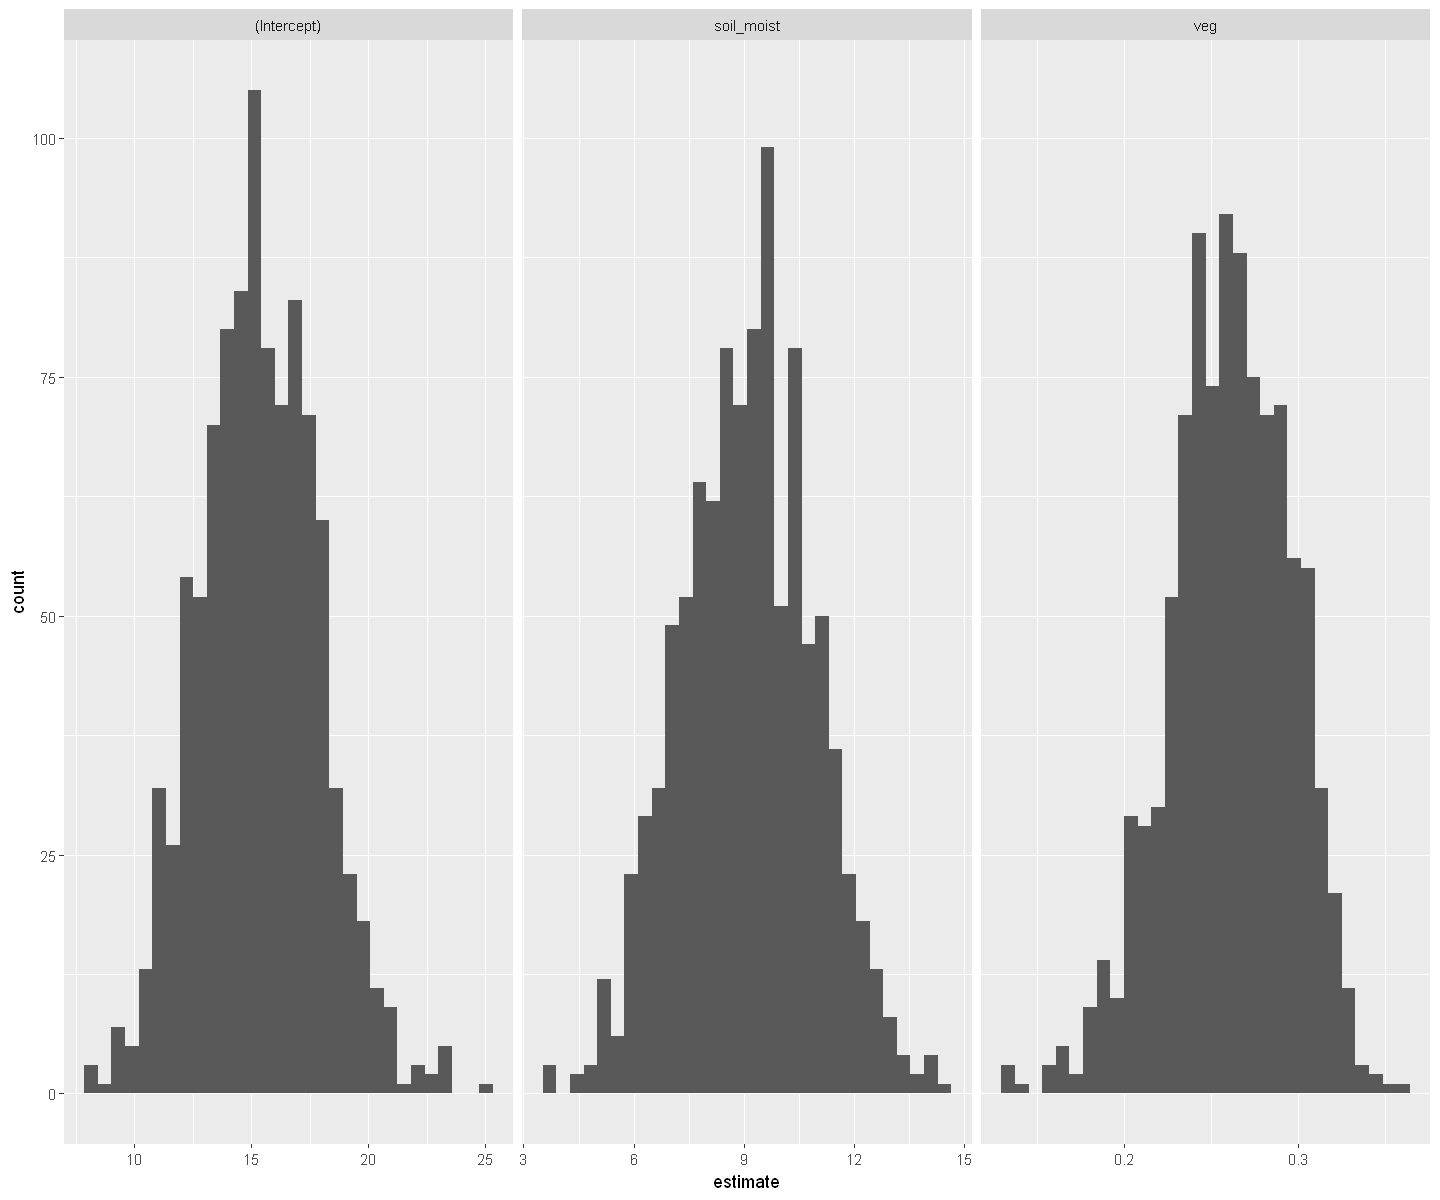

In [ ]:
ggplot(reg_tables, aes(x = estimate)) +
  geom_histogram() +
  facet_wrap(~term, scales = "free_x")

Use the percentile method to find the bounds of a 95% confidence interval for the `veg` coefficient.

In [32]:
reg_tables |>
    group_by(term) |>
    summarize(lower_ci = quantile(estimate, 0.025, na.rm = T), upper_ci = quantile(estimate, 0.975, na.rm = T))

term,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
(Intercept),10.5937133,20.491022
soil_moist,5.6779622,12.637349
veg,0.1877815,0.322213


What can we say about the relationship of `voles` and  `veg`?

CI does not contain zero.<br />
A plausible range of values for the veg parameter only includes positive values.<br />
We can conclude that the relationship between voles and veg is positive in direction.